In [1]:
# Import needed libraries
import os
import pandas as pd
import pandas_datareader
from pandas_datareader import data
import numpy as np
import panel as pn
pn.extension('plotly')
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import matplotlib.dates as mdates
import yfinance as yf

In [2]:
# set the ticker
tickers = ['SPY']

# extract data from 01/01/1992 to 12/31/2021.
start_date = datetime.date(1997,1,1)
end_date = datetime.date(2021,12,31)
years = round((end_date - start_date).days/365,0)
years

25.0

In [3]:
# Use data.DataReader to load the data
panel_data = data.DataReader("SPY", "yahoo", start_date, end_date)

# Checkout the data type
type(panel_data)

pandas.core.frame.DataFrame

In [4]:
# checkout the data
panel_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1997-01-02,74.37500,72.750000,74.37500,74.03125,2031900.0,47.419106
1997-01-03,75.12500,74.078125,74.37500,75.09375,2123200.0,48.099682
1997-01-06,75.43750,74.312500,75.09375,74.43750,1374100.0,47.679333
1997-01-07,75.46875,74.125000,74.43750,75.34375,939000.0,48.259781
1997-01-08,75.78125,74.687500,75.75000,74.68750,1802200.0,47.839455


In [5]:
# filter the data
close_price = panel_data.drop(columns = ["High", "Low", "Open", "Volume", "Adj Close"])
close_price.head()

,Close
Date,
1997-01-02,74.03125
1997-01-03,75.09375
1997-01-06,74.43750
1997-01-07,75.34375
1997-01-08,74.68750


In [6]:
# get info about the data
close_price.describe()

,Close
count,6293.000000
mean,169.189590
std,83.419133
min,68.110001
25%,113.660004
50%,135.360001
75%,207.259995
max,477.480011


In [7]:
# Identify frequency of values
close_price.value_counts()

Close     
131.970001    6
107.000000    6
114.199997    5
95.625000     5
129.740005    4
             ..
127.656250    1
127.639999    1
127.620003    1
127.599998    1
477.480011    1
Length: 5290, dtype: int64

In [8]:
# Check for null values
close_price.isnull()

,Close
Date,
1997-01-02,False
1997-01-03,False
1997-01-06,False
1997-01-07,False
1997-01-08,False
...,...
2021-12-27,False
2021-12-28,False
2021-12-29,False


In [9]:
# Determine percentage of nulls
close_price.isnull().mean() * 100

Close    0.0
dtype: float64

In [10]:
# Check for duplicated values
close_price.duplicated()

Date
1997-01-02    False
1997-01-03    False
1997-01-06    False
1997-01-07    False
1997-01-08    False
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31    False
Length: 6293, dtype: bool

In [11]:
# check number of duplicates
close_price.duplicated().sum()

1003

<AxesSubplot:xlabel='Date'>

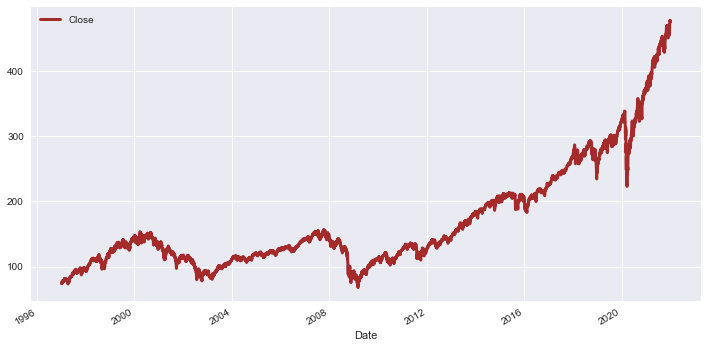

In [12]:
# data visualization
close_price.plot(color='brown', linewidth=3, figsize=(12,6))

In [13]:
# calculations:

inital_investment = 10000
max_spy = close_price["Close"].max()
min_spy = close_price["Close"].min()

In [14]:
# Calculate returns for SPY as a benchmark
spy_daily_return = close_price [["Close"]]
spy_daily_return = spy_daily_return.pct_change()
spy_daily_return.rename(columns= {"Close" : "BM Daily Return"}, inplace = True)

In [15]:
# calculate the cumulative returns 
spy_daily_return["BM Cumulative Return"] = (1 + spy_daily_return["BM Daily Return"]).cumprod().sub(1)
spy_daily_return.dropna(inplace = True)
spy_daily_return

,BM Daily Return,BM Cumulative Return
Date,,
1997-01-03,0.014352,0.014352
1997-01-06,-0.008739,0.005488
1997-01-07,0.012175,0.017729
1997-01-08,-0.008710,0.008864
1997-01-09,0.008368,0.017307
...,...,...
2021-12-27,0.014152,5.446737
2021-12-28,-0.000817,5.441469
2021-12-29,0.001279,5.449709


In [16]:
# total return 
total_return = (spy_daily_return["BM Cumulative Return"][-1])
print(total_return)

5.415668943251349


In [17]:
# calculate CAGR compound annual growth rate
# Our CAGR seems to be too big!
cagr_pct = round((((spy_daily_return["BM Cumulative Return"][-1]/spy_daily_return["BM Cumulative Return"][0])**(1/years)) - 1)*100, 2)
print(cagr_pct)

26.79


In [18]:
# Calculate standard deviation for SPY
annualized_std_spy = round(spy_daily_return["BM Daily Return"].std()*np.sqrt(252),2)
annualized_std_spy

0.2

In [19]:
# Calculate Sharpe Ratio for SPY
# why our sharpe ratio is too small? It's supposed to be over 1 or even over 2!
sharpe_ratio_spy = (spy_daily_return["BM Daily Return"].mean()/annualized_std_spy)
sharpe_ratio_spy

0.0018641983352493104

In [20]:
# Calculate benchmark drawdown
spy_daily_return["Peak Cummulative"] = spy_daily_return["BM Cumulative Return"].cummax()
spy_daily_return["Daily Drawdown"] = spy_daily_return["BM Cumulative Return"] - spy_daily_return["Peak Cummulative"]
bm_drawdown_pct = round(((spy_daily_return["Daily Drawdown"]/spy_daily_return["Peak Cummulative"]).min())*100,2)
bm_drawdown_pct

-108.37

In [21]:
# SMAs are calculated on closing prices and not adjusted close; 
# because we want the trade signal to be generated on the price data and not influenced by dividends paid.

In [22]:
# Backtesting 20 EMA crossing 50 SMA
# Define variables
fast_ma_3 = 20
slow_ma_3 = 50
strategy3 = close_price[["Close"]]

In [23]:
# Calculate 20 EMA and 50 SMA
strategy3["20_EMA"] = strategy3["Close"].ewm(span = fast_ma_3, adjust = False).mean()
strategy3["50_SMA"] = strategy3["Close"].rolling(window = slow_ma_3).mean()
strategy3

,Close,20_EMA,50_SMA
Date,,,
1997-01-02,74.031250,74.031250,NaN
1997-01-03,75.093750,74.132440,NaN
1997-01-06,74.437500,74.161494,NaN
1997-01-07,75.343750,74.274090,NaN
1997-01-08,74.687500,74.313462,NaN
...,...,...,...
2021-12-27,477.260010,465.494746,462.443001
2021-12-28,476.869995,466.578103,463.063001
2021-12-29,477.480011,467.616380,463.668801


<function __main__.strategy3_plot()>

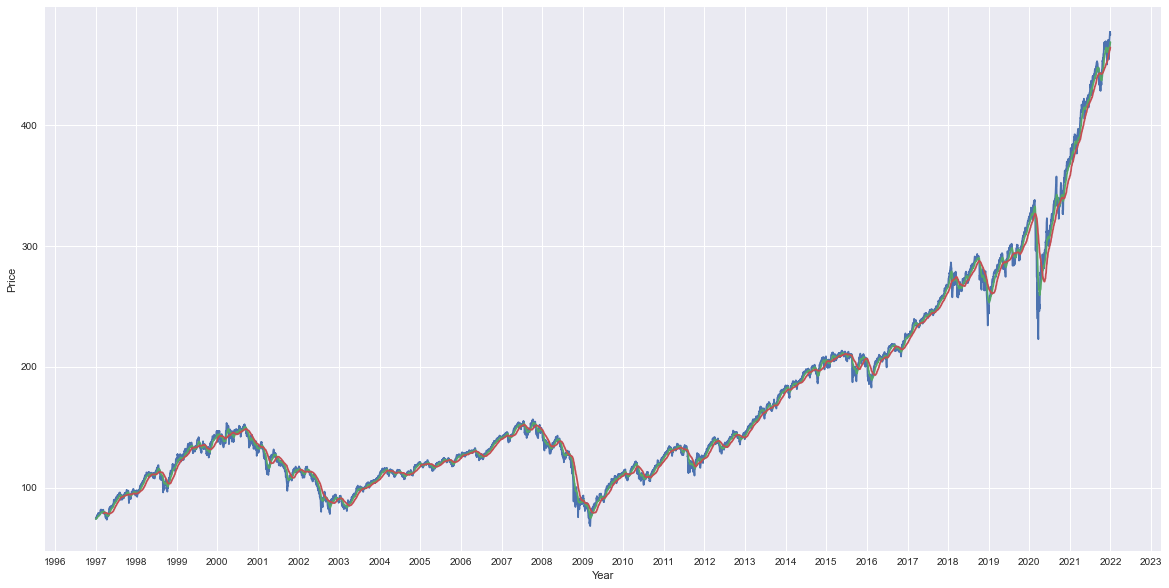

In [24]:
# Plot a graph
def strategy3_plot ():
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(strategy3)
    ax.set(xlabel = "Year",
    ylabel = "Price")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    return strategy3_plot
strategy3_plot()

In [25]:
benchmark_spy = spy_daily_return[["BM Daily Return"]]
benchmark_spy

,BM Daily Return
Date,
1997-01-03,0.014352
1997-01-06,-0.008739
1997-01-07,0.012175
1997-01-08,-0.008710
1997-01-09,0.008368
...,...
2021-12-27,0.014152
2021-12-28,-0.000817
2021-12-29,0.001279


In [26]:
strategy3_return = pd.concat([strategy3,benchmark_spy],axis=1, join = "inner")
strategy3_return["Long Position"] = strategy3['20_EMA'] > strategy3["50_SMA"]
strategy3_return.head()

,Close,20_EMA,50_SMA,BM Daily Return,Long Position
Date,,,,,
1997-01-03,75.09375,74.132440,NaN,0.014352,False
1997-01-06,74.43750,74.161494,NaN,-0.008739,False
1997-01-07,75.34375,74.274090,NaN,0.012175,False
1997-01-08,74.68750,74.313462,NaN,-0.008710,False
1997-01-09,75.31250,74.408608,NaN,0.008368,False


In [27]:
strategy3_return["Strategy3 Return"] = np.where(strategy3_return["Long Position"].shift(1) == True, strategy3_return["BM Daily Return"], 0)
strategy3_return.tail()

,Close,20_EMA,50_SMA,BM Daily Return,Long Position,Strategy3 Return
Date,,,,,,
2021-12-27,477.260010,465.494746,462.443001,0.014152,True,0.014152
2021-12-28,476.869995,466.578103,463.063001,-0.000817,True,-0.000817
2021-12-29,477.480011,467.616380,463.668801,0.001279,True,0.001279
2021-12-30,476.160004,468.430058,464.179201,-0.002765,True,-0.002765
2021-12-31,474.959991,469.051957,464.630201,-0.002520,True,-0.002520


In [28]:
strategy3_return["Strategy3 Cumulative Return"] = (1+ strategy3_return["Strategy3 Return"]).cumprod().sub(1)
strategy3_return

,Close,20_EMA,50_SMA,BM Daily Return,Long Position,Strategy3 Return,Strategy3 Cumulative Return
Date,,,,,,,
1997-01-03,75.093750,74.132440,NaN,0.014352,False,0.000000,0.000000
1997-01-06,74.437500,74.161494,NaN,-0.008739,False,0.000000,0.000000
1997-01-07,75.343750,74.274090,NaN,0.012175,False,0.000000,0.000000
1997-01-08,74.687500,74.313462,NaN,-0.008710,False,0.000000,0.000000
1997-01-09,75.312500,74.408608,NaN,0.008368,False,0.000000,0.000000
...,...,...,...,...,...,...,...
2021-12-27,477.260010,465.494746,462.443001,0.014152,True,0.014152,1.091026
2021-12-28,476.869995,466.578103,463.063001,-0.000817,True,-0.000817,1.089318
2021-12-29,477.480011,467.616380,463.668801,0.001279,True,0.001279,1.091990


In [29]:
# Plot with the benchmark
def strategy3_return_plot ():
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(spy_daily_return["BM Cumulative Return"])
    ax.plot(strategy3_return["Strategy3 Cumulative Return"])
    ax.set(xlabel = "Year",
    ylabel = "Profit")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    return strategy3_return_plot

<function __main__.strategy3_return_plot()>

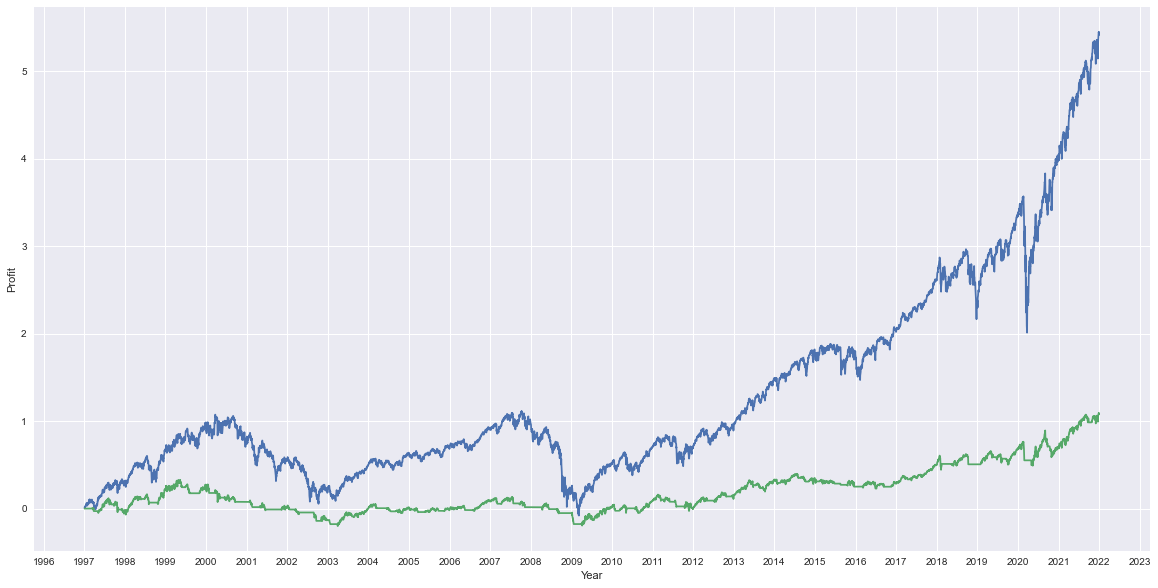

In [30]:
strategy3_return_plot()

In [31]:
# Calculate strategy 3 total return and CAGR
strategy3_total_return_pct = round((strategy3_return["Strategy3 Cumulative Return"][-1]/strategy3_return["Strategy3 Cumulative Return"][0] - 1) * 100, 2)
strategy3_cagr_pct = round((((strategy3_return["Strategy3 Cumulative Return"][-1]/strategy3_return["Strategy3 Cumulative Return"][0])**(1/years))-1)*100,2)

C:\Users\HOANG\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\HOANG\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
print(strategy3_total_return_pct)

inf


In [33]:
print(strategy3_cagr_pct)

inf


In [34]:
# Calculate standard deviation
strategy3_annualized_std = round(strategy3_return["Strategy3 Return"].std()*np.sqrt(252),2)
strategy3_annualized_std

0.12

In [35]:
# Calculate sharpe ratio
strategy3_sharpe_ratio = round((strategy3_return["Strategy3 Return"].mean() * 252)/strategy3_annualized_std,2)
strategy3_sharpe_ratio

0.3

In [36]:
# Calculate Drawdown strategy 3
strategy3_return["Strategy3 Peak Cummulative"] =strategy3_return["Strategy3 Cumulative Return"].cummax()
strategy3_return["Strategy3 Daily Drawdown"] = strategy3_return["Strategy3 Cumulative Return"] - strategy3_return["Strategy3 Peak Cummulative"]

In [37]:
strategy3_drawdown_pct = round(((strategy3_return["Strategy3 Daily Drawdown"]/ strategy3_return["Strategy3 Peak Cummulative"]).min())*100,2)
strategy3_drawdown_pct

-742.06

In [38]:
# Summary of the strategy 3
